# Final Report - Binary Image Classification with CNN

### Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import os
from glob import glob
from skimage import io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, Activation, MaxPooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2


### Reading in dataset

In [2]:
# read in our spreadsheet for the dataset
data_df = pd.read_excel("C:\\Users\\Katrina Peralta\\Downloads\\Imaging Final Report\\cnn_labels_binary.xlsx")

### Shuffling dataset

In [3]:
'''
import random

# shuffle the entire datasheet (rows)
data_shuffled = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

# save the shuffled data back to Excel
data_shuffled.to_excel('shuffled_data.xlsx', index=False)  

print("Data shuffled and saved successfully!")
data_shuffled
'''

'\nimport random\n\n# shuffle the entire datasheet (rows)\ndata_shuffled = data_df.sample(frac=1, random_state=42).reset_index(drop=True)\n\n# save the shuffled data back to Excel\ndata_shuffled.to_excel(\'shuffled_data.xlsx\', index=False)  \n\nprint("Data shuffled and saved successfully!")\ndata_shuffled\n'

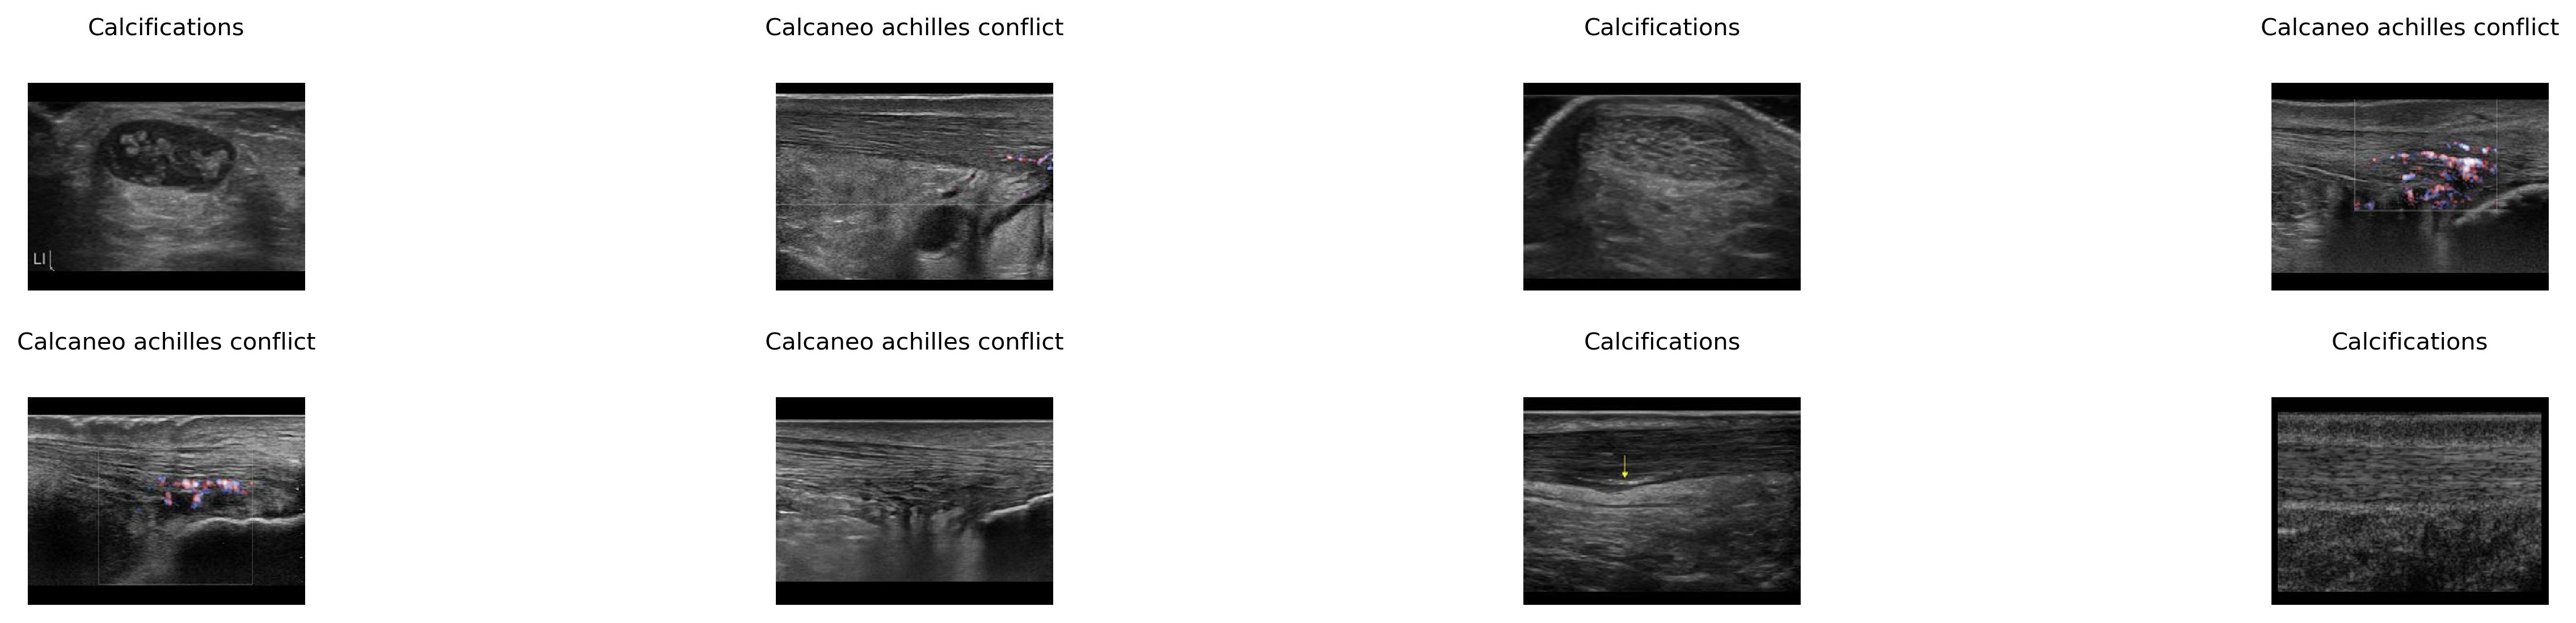

In [4]:
# Let us look at a sample of 8 images in more detail:
number_of_images = 8
images = []

for num, image_path in enumerate(data_df['path']):
    # load image and add to list
    img = io.imread(f'{image_path}')
    images.append(img)
    
    if num == number_of_images:
        break
    
# plot the data
_, axes = plt.subplots(2, 4, dpi=300, figsize=(20,4))
axes = axes.flatten()
images_and_labels = list(zip(images[:number_of_images], data_df['diagnosis'].values[:number_of_images]))
for ax, (image, label) in zip(axes[:], images_and_labels):
    ax.set_axis_off()
    ax.set_title(label, fontsize = 10, pad=20)
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')

# Adjust the layout for better spacing
plt.subplots_adjust(wspace=0.9, hspace=0.5)  # Increase horizontal space between images
plt.show()

### Labeling the data

#### Using binary encoding to distinguish between each category:
We can simply implement a binary encoding:
* Image of calcaneal achilles conflict -> `1`
* Image of calcification -> `0`


In [5]:
# Note: np.where(condition, value if true , value if false)
data_df['label'] = np.where(data_df['diagnosis']=='Calcaneo achilles conflict', 1, 0)
data_df

,img,path,diagnosis,label
0,96,dataset\096.jpg,Calcifications,0
1,52,dataset\052.jpg,Calcaneo achilles conflict,1
2,83,dataset\083.jpg,Calcifications,0
3,20,dataset\020.jpg,Calcaneo achilles conflict,1
4,21,dataset\021.jpg,Calcaneo achilles conflict,1
...,...,...,...,...
150,87,dataset\087.jpg,Calcifications,0
151,108,dataset\108.jpg,Calcifications,0
152,54,dataset\054.jpg,Calcaneo achilles conflict,1
153,124,dataset\124.jpg,Calcifications,0


### Looking at distribution of labels

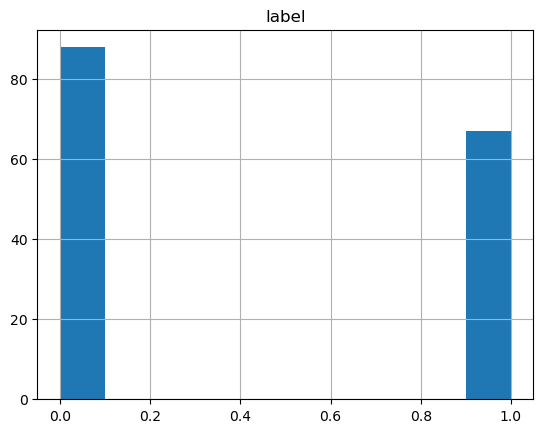

In [6]:
data_df.hist('label')
plt.show()

### Generating training and validation models

In [7]:
from sklearn.model_selection import train_test_split

split_size = .2

train_df, valid_df = train_test_split(data_df, test_size = split_size, random_state = 2022) 
print(f'train {train_df.shape[0]}, validation {valid_df.shape[0]}')

train 124, validation 31


### Data augmentation

In [8]:
# Here we make the data generators for loading and randomly transforming images
datgen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True, 
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.05, 
    width_shift_range=0.1, 
    rotation_range=5, 
    shear_range = 0.1,
    fill_mode = 'reflect',
    zoom_range=0.15
)

### Defining CNN

In [ ]:
from IPython.display import display, clear_output

label_layout = widgets.Layout(width='500px',height='30px')
style = {'description_width': 'initial'}

build_btn = widgets.Button(
    description='Build Model',
    button_style='info', # 'success', 'info', 'warning', 'danger' or '
    icon='cog', # (FontAwesome names without the fa- prefix)
    layout = label_layout
)
output = widgets.Output()

def imgplot(d):
    plt.style.use('default')
    fig, axes = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8,8))
    arr = io.imread('ICMnet.png')
    axes.set_axis_off()
    axes.imshow(arr, interpolation='nearest', cmap=plt.cm.gray)
    return plt.show()

slider_1 = widgets.IntSlider(value=8,step=2,description='S1: depth of 1st Conv Layer',min=2,max=8, style = style, layout = label_layout)
slider_2 = widgets.IntSlider(value=16,step=2,description='S2: depth of 2nd Conv Layer',min=2,max=16, style = style, layout = label_layout)
slider_3 = widgets.IntSlider(value=32,step=2,description='S3: depth of 3rd Conv Layer',min=2,max=32, style = style, layout = label_layout)

# this is where we define our CNN model
def build_model(x):
    
    model = Sequential()
    model.add(Conv2D(slider_1.value, (6, 6), padding='same',input_shape=(28,28,1),name = 'conv2D_1'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    #model.add(SpatialDropout2D(0.1)) # Dropout layers are usefull if your model tends to overfit! 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(slider_2.value, (3, 3),name = 'conv2D_2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    #model.add(SpatialDropout2D(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(slider_3.value, (3, 3),name = 'conv2D_3')) #feature_slider
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(SpatialDropout2D(0.1))
    
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = keras.optimizers.RMSprop(learning_rate=0.01)#(learning_rate=0.01)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy', 'mae'])
    
    #print the model summary
    with output:
        clear_output()
        print(model.summary())
    #return model 
    global conv_model
    conv_model = model

        
lab = widgets.Label(value="A graphic illustration of the Convolutional Neural Network:")
out = widgets.interactive(imgplot, d = lab)
v_grid = widgets.VBox((slider_1, slider_2, slider_3, build_btn, output))
h_grid = widgets.HBox((v_grid,out))
display(h_grid)
build_btn.on_click(build_model)

     img             path                   diagnosis label
39    27  dataset\027.jpg  Calcaneo achilles conflict     1
36    58  dataset\058.jpg  Calcaneo achilles conflict     1
74    56  dataset\056.jpg  Calcaneo achilles conflict     1
124   99  dataset\099.jpg              Calcifications     0
67   120  dataset\120.jpg              Calcifications     0
Number of validation samples: 31
Found 124 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.
Number of validation samples: 31
['1' '0']
Validation Steps:  1
Epoch 1/30
4/4 [==============================] - 2s 381ms/step - loss: 1.0768 - binary_accuracy: 0.5645 - mae: 0.4493 - val_loss: 0.7911 - val_binary_accuracy: 0.5161 - val_mae: 0.4720
Epoch 2/30
4/4 [==============================] - 1s 315ms/step - loss: 0.6002 - binary_accuracy: 0.6613 - mae: 0.4069 - val_loss: 0.8621 - val_binary_accuracy: 0.6452 - val_mae: 0.3746
Epoch 3/30
4/4 [==============================] - 1s

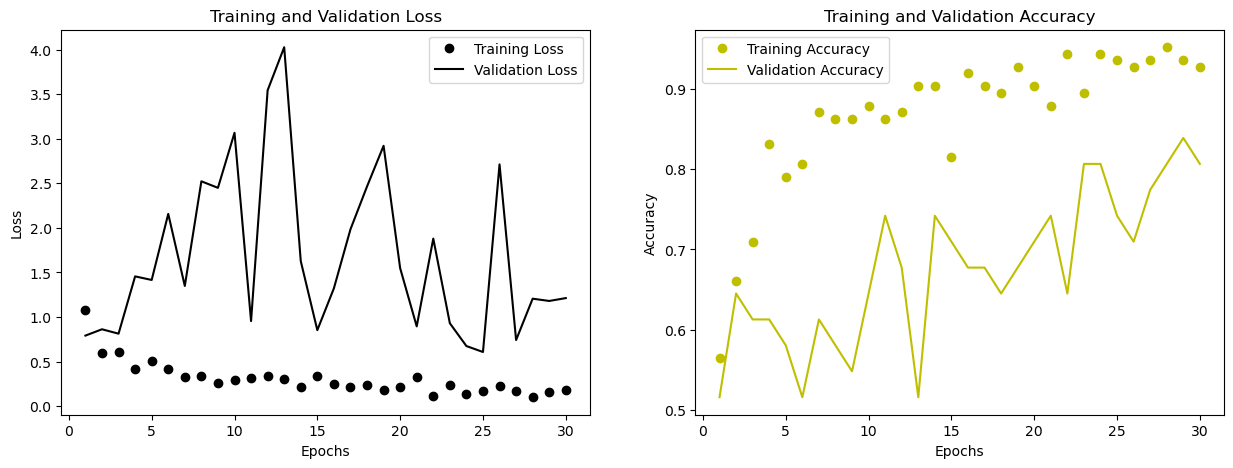

In [11]:
# debugging
#print(train_df.columns)
#print(valid_df.columns)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

print(valid_df.head())
print("Number of validation samples:", len(valid_df))

train_generator=datgen.flow_from_dataframe(dataframe=train_df, directory="", x_col="path", y_col="label", class_mode="binary", color_mode = 'grayscale', target_size=(28,28), batch_size=31)
valid_generator=datgen.flow_from_dataframe(dataframe=valid_df, directory="", x_col="path", y_col="label", class_mode="binary", color_mode = 'grayscale', target_size=(28,28), batch_size=31)

# debugging
print("Number of validation samples:", valid_generator.n)
print(valid_df['label'].unique())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Validation Steps: ", STEP_SIZE_VALID)

history = conv_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30)

print(history.history.keys())

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# print(len(history.history['val_loss']))
print("Training Loss Length: ", len(loss))
print("Validation Loss Length: ", len(val_loss))

if len(val_loss) > len(loss):
    val_loss = val_loss[:len(loss)]

if len(loss) != len(val_loss):
    print(f"Length mismatch. Training Loss Length: {len(loss)}, Validation Loss Length: {len(val_loss)}")
'''
if len(history.history['val_loss']) == len(history.history['loss']):
    val_loss = history.history['val_loss']
else:
    print("Inconsistent lengths in training and validation loss.")
    val_loss = history.history['val_loss'][:len(loss)]
'''
epochs = range(1, len(loss)+1)

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(epochs, loss, 'ko', label = 'Training Loss')
axes[0].plot(epochs, val_loss, 'k', label = 'Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(epochs, acc, 'yo', label = 'Training Accuracy')
axes[1].plot(epochs, val_acc, 'y', label = 'Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
plt.show()

### Model Evaluation
* How well does our model distinguish each case on the testing data?

Found 31 validated image filenames.
1/1 [==============================] - 0s 101ms/step


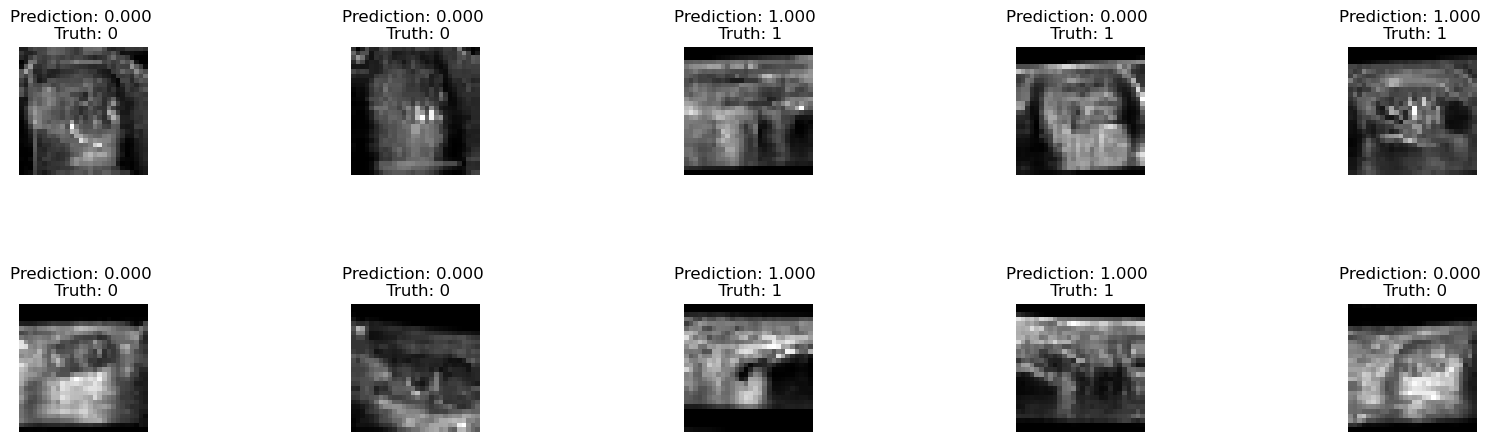

In [12]:
test_X, test_Y = next(datgen.flow_from_dataframe(dataframe=valid_df, directory="", x_col="path", y_col="label", class_mode="raw", color_mode = 'grayscale', target_size=(28,28), batch_size=300))
pred_Y = conv_model.predict(test_X, batch_size = 250, verbose = True)
pred_Y = np.round(pred_Y).astype(int)

results = pd.DataFrame({'predict':np.round(pred_Y.T[0]),'test':test_Y})

_, axes = plt.subplots(2, 5, figsize=(20,5))
axes = axes.flatten()
images_and_predictions = list(zip(test_X, pred_Y, test_Y))
for ax, (image, prediction, label) in zip(axes[:], images_and_predictions[20:30]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title(f'Prediction: {round(prediction[0],3):.3f} \n Truth: {label}')

plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### Grad-CAM

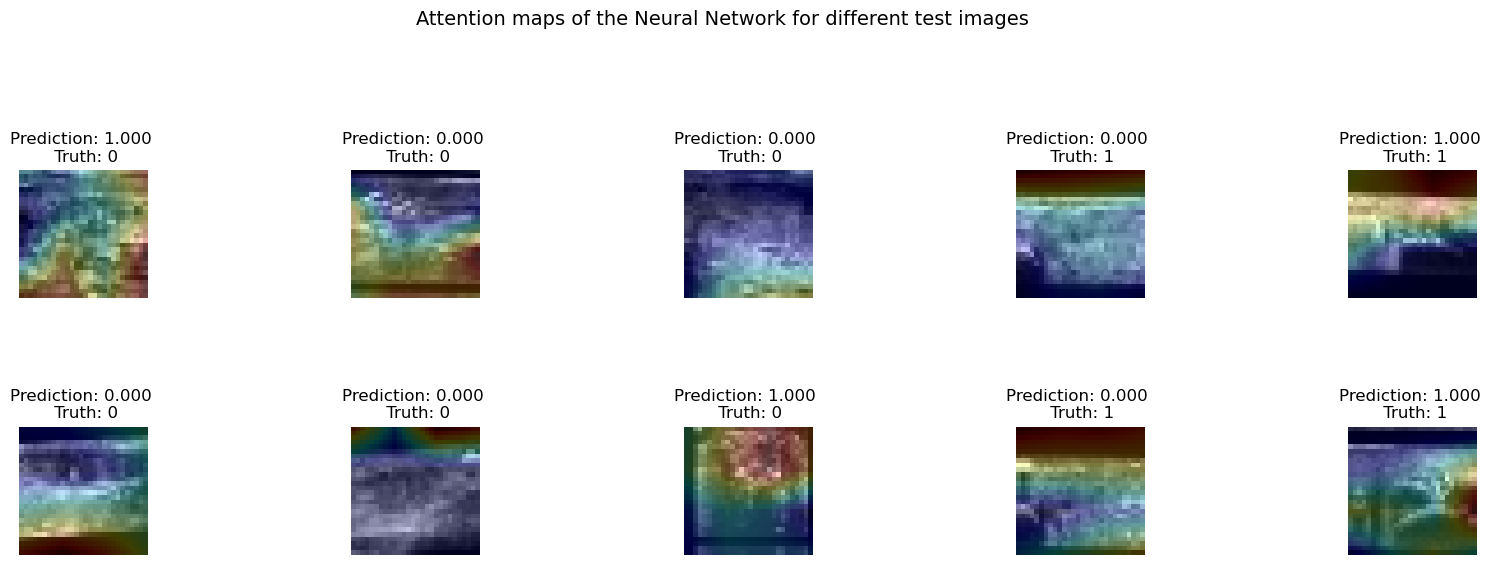

In [13]:
import tensorflow as tf
from matplotlib import cm
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import GradcamPlusPlus

def model_modifier(m):
    m.layers[-1].activation = keras.activations.linear
    return m

def loss(output):
    return output[0]

fig, axes = plt.subplots(2, 5, figsize=(20,5))
axes = axes.flatten()
images_and_predictions = list(zip(test_X, pred_Y, test_Y))

for ax, (image, prediction, label) in zip(axes[:], images_and_predictions[10:20]):
    ax.set_axis_off()
    gradcam = GradcamPlusPlus(conv_model,
                          model_modifier,
                          clone=False)
    # Generate heatmap with GradCAM++
    cam = gradcam(loss,
                  image,
                  penultimate_layer=-1, # model.layers number
                 )
    cam = normalize(cam)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax.imshow(heatmap, cmap='jet', alpha=0.25)
    ax.set_title(f'Prediction: {round(prediction[0],3):.3f} \n Truth: {label}')
fig.suptitle('Attention maps of the Neural Network for different test images', fontsize=14, y=1.2);

plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### Model Performance

Using the confusion Matrix to calculate various **metrics** such as:

* Accuracy = $ \frac{TP + TN}{TP+TN+FP+FN} $
* Sensitivity = $ \frac{TP}{TP+FN} $ (also known as Recall or True Positive Rate)
* Specificity = $ \frac{TN}{TN+FP} $ (also known as True Negative Rate)
* Precision = $ \frac{TP}{TP+FP} $
* F1 score = $ \frac{2*TP}{2*TP+FP+FN} $ (harmonic mean of Precision and Sensitivity)

{'0': {'precision': 0.6666666666666666, 'recall': 0.75, 'f1-score': 0.7058823529411765, 'support': 16.0}, '1': {'precision': 0.6923076923076923, 'recall': 0.6, 'f1-score': 0.6428571428571429, 'support': 15.0}, 'accuracy': 0.6774193548387096, 'macro avg': {'precision': 0.6794871794871795, 'recall': 0.675, 'f1-score': 0.6743697478991597, 'support': 31.0}, 'weighted avg': {'precision': 0.6790736145574855, 'recall': 0.6774193548387096, 'f1-score': 0.6753862835456764, 'support': 31.0}}


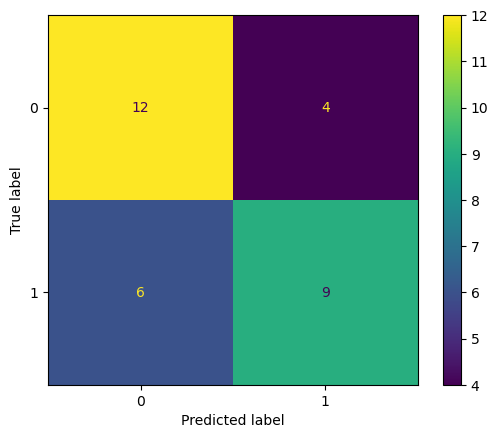

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

test_Y = test_Y.astype(int)

report = classification_report(test_Y, np.round(pred_Y.T[0]), output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('Classification_Report.csv', index=True)
print(report)


cm = confusion_matrix(test_Y, np.round(pred_Y.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot() 